In [2]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
from requests import get
import re
import geopandas as gpd
import matplotlib as plt
from matplotlib import pyplot as plt
from geopy.extra.rate_limiter import RateLimiter
import numpy as np

### 1.	Выгружаю с сайта продуктовой сети все магазины. Обязательная информация, которая должна присутствовать:
- Город
-	Адрес
-	Координаты

	Финальный файл будет в формате shp (“utf-8”, crs = “epsg: 4326” - GCS WGS 84)


In [55]:
#ищем всевозможные id магазинов
r = get('https://******.ru/**********?bbox=10.0000,10.0000,100.0000,100.0000')
text_stores = r.text
 
id_stores = re.findall(r'"id":(.*?),"options"', text_stores)

In [146]:
# print(len(id_stores))
 
# print(id_stores)

In [71]:
#построение словаря с нужными по условию данными
result = {'id_store':response['id'], 
          'city':response['properties']['city_name'], 
          'address':response['properties']['address'], 
          'latitude':response['geometry']['coordinates'][0], 
          'longitude':response['geometry']['coordinates'][1]}
result

{'id_store': 18555,
 'city': 'г. Казань',
 'address': 'Проточная ул., 6',
 'latitude': 55.81375368,
 'longitude': 49.08525373}

In [65]:
#для получения названия города, добавляю к базовому адресу переменную id для парсинга

all_refs = list(map(lambda x: 'https://***********/api/stores/' + x, id_stores))
# all_refs

In [72]:
#финальный срипт
fin_result = pd.DataFrame()
for ref in all_refs:
    data = requests.get(ref).json()
    result = {'id_store':data['id'], 
          'city':data['properties']['city_name'], 
          'address':data['properties']['address'], 
          'latitude':data['geometry']['coordinates'][0], 
          'longitude':data['geometry']['coordinates'][1]}
    fin_result = pd.concat([fin_result, pd.DataFrame([result])])

In [4]:
#удаляем нулевой индекс и получаем 16198 точек предприятия
finer.drop(finer.columns[finer.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
finer.tail()

,id_store,city,address,latitude,longitude
16193,22334,г. Санкт-Петербург,"Народная ул., 33",59.881128,30.468815
16194,25965,пгт. Красная Поляна,"ул. Защитников Кавказа, 1",43.673042,40.198508
16195,9937,г. Санкт-Петербург,"набережная реки Фонтанки, 121",59.920675,30.311134
16196,8544,г. Бабаево,"ул. Свердлова, 3В",59.397172,35.942513
16197,24566,ст-ца Пластуновская,"Сквозная ул., 39",45.296131,39.248755


In [7]:
#добавляем геометрию 
gdf = gpd.GeoDataFrame(
    finer, geometry=gpd.points_from_xy(finer.longitude, finer.latitude))

In [8]:
gdf.head()

,id_store,city,address,latitude,longitude,geometry
0,9745,г. Оренбург,"Волгоградская ул., 32",51.841031,55.127926,POINT (55.12793 51.84103)
1,9750,г. Мурманск,"ул. Александрова, 20",68.996044,33.082498,POINT (33.08250 68.99604)
2,21787,пгт. Ветлужский,"ул. Калинина, 4",58.393128,45.474176,POINT (45.47418 58.39313)
3,21848,г. Троицк,"Краснопартизанская ул., 2",54.097130,61.561660,POINT (61.56166 54.09713)
4,21796,с. Кушнаренково,"Октябрьская ул., 71",55.104912,55.353273,POINT (55.35327 55.10491)


<AxesSubplot:>

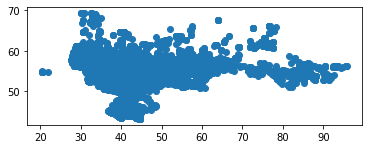

In [19]:
#все торговые точки в РФ распределены так
gdf.plot()

In [25]:
gdf.crs = "EPSG:4326"

In [9]:
gdf.to_file("file.shp", encoding='utf-8') #сохраняем в .shp

### 2. Выбрал произвольный геокодер. На вход адрес или координаты, на выход координаты и/или адрес.

In [ ]:
# https://github.com/hflabs/dadata-py

In [6]:
#вбиваем координаты, на выходе получаем адрес

from dadata import DadataAsync
token = '3d608dc362ae56beac254b566c4a902b4fe90291'
dadata = DadataAsync(token)
result = await dadata.geolocate(name = "address", lat=55.6792269, lon = 37.4553939)
result[0]['value']

/Users/mouz/opt/anaconda3/lib/python3.8/site-packages/httpx/_client.py:1781: UserWarning: Unclosed <httpx.AsyncClient object at 0x7fa1e68fb0d0>. See https://www.python-httpx.org/async/#opening-and-closing-clients for details.
  warnings.warn(


'г Москва, ул Озёрная, д 20'

In [7]:
# вбиваем адрес, на выходе получаем координаты 
import dadata
from dadata import DadataAsync
token = "3d608dc362ae56beac254b566c4a902b4fe90291"
secret = "96ea0b092420a8c8fde0996c1c3ad21b1d7eff67"
dadata = DadataAsync(token, secret)
result = await dadata.clean("address", str(input()))
tes = {'latitude':result['geo_lat'], 'longitude':result['geo_lon']}
tes

Респ. Татарстан, р-н. Агрызский, г. Агрыз, ул. Деповская, д. 5


{'latitude': '56.523197', 'longitude': '52.9992189'}

### 3.	Выгружаю на Москву и/или Московскую область административное деление вплоть до уровня. Финальный слой в виде shp (для дальнейшей работы с пространством).

In [2]:
# Путь к папке data в моём архиве
ZIP_PATH = 'zip://RU-MOW-58680b55-20201023-ru-shape.zip!data/'

# Названия для переменных слоев и названия соответствующих shp файлов
LAYERS_DICT = {
    'boundary_L4': 'boundary-polygon-lvl4.shp',
    'boundary_L5': 'boundary-polygon-lvl5.shp',
    'boundary_L8': 'boundary-polygon-lvl8.shp',
    'building_point': 'building-point.shp',  # Здания, отмеченные в виде полигонов
    'building_poly': 'building-polygon.shp'  # Здания, отмеченные в виде точек
              }

# Подгружаем слои в переменные
i = 0
for layer in LAYERS_DICT.keys():

    path_to_layer = ZIP_PATH + LAYERS_DICT[layer]

    if layer[:8]=='boundary':
        encoding = 'utf-8'
    else:
        encoding = 'utf-8'
    globals()[layer] = gpd.read_file(path_to_layer, encoding='utf-8')

    i+=1
    print(f'[{i}/{len(LAYERS_DICT)}] LOADED {layer} WITH ENCODING')

[1/5] LOADED boundary_L4 WITH ENCODING
[2/5] LOADED boundary_L5 WITH ENCODING
[3/5] LOADED boundary_L8 WITH ENCODING
[4/5] LOADED building_point WITH ENCODING
[5/5] LOADED building_poly WITH ENCODING


<AxesSubplot:>

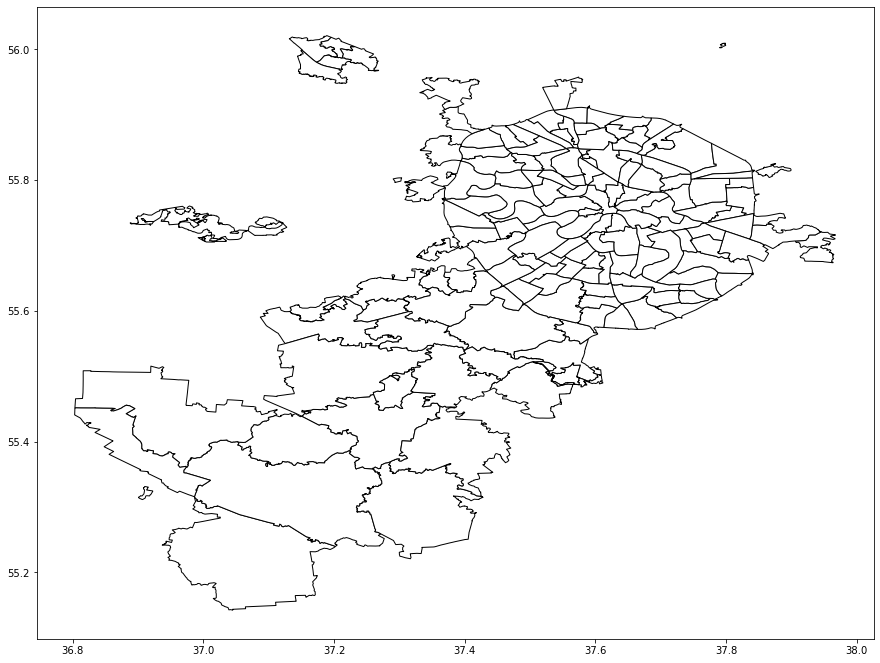

In [16]:
#простой и самый быстрый вариант по районам

fig, (ax4) = plt.subplots(1, 1, figsize=(15,15))
boundary_L8.plot(ax=ax4, color='white', edgecolor='black')

<AxesSubplot:>

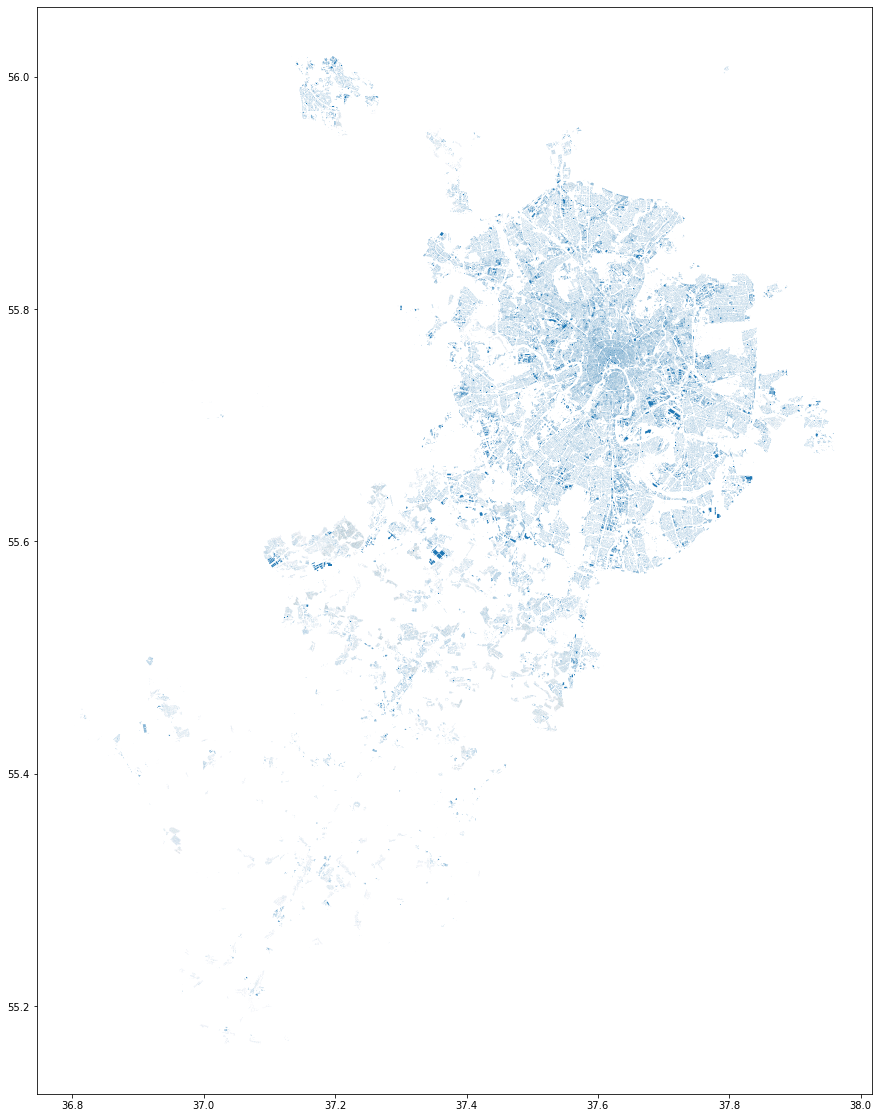

In [36]:
#со зданиями
building_poly.plot(figsize=(20,20))

<AxesSubplot:>

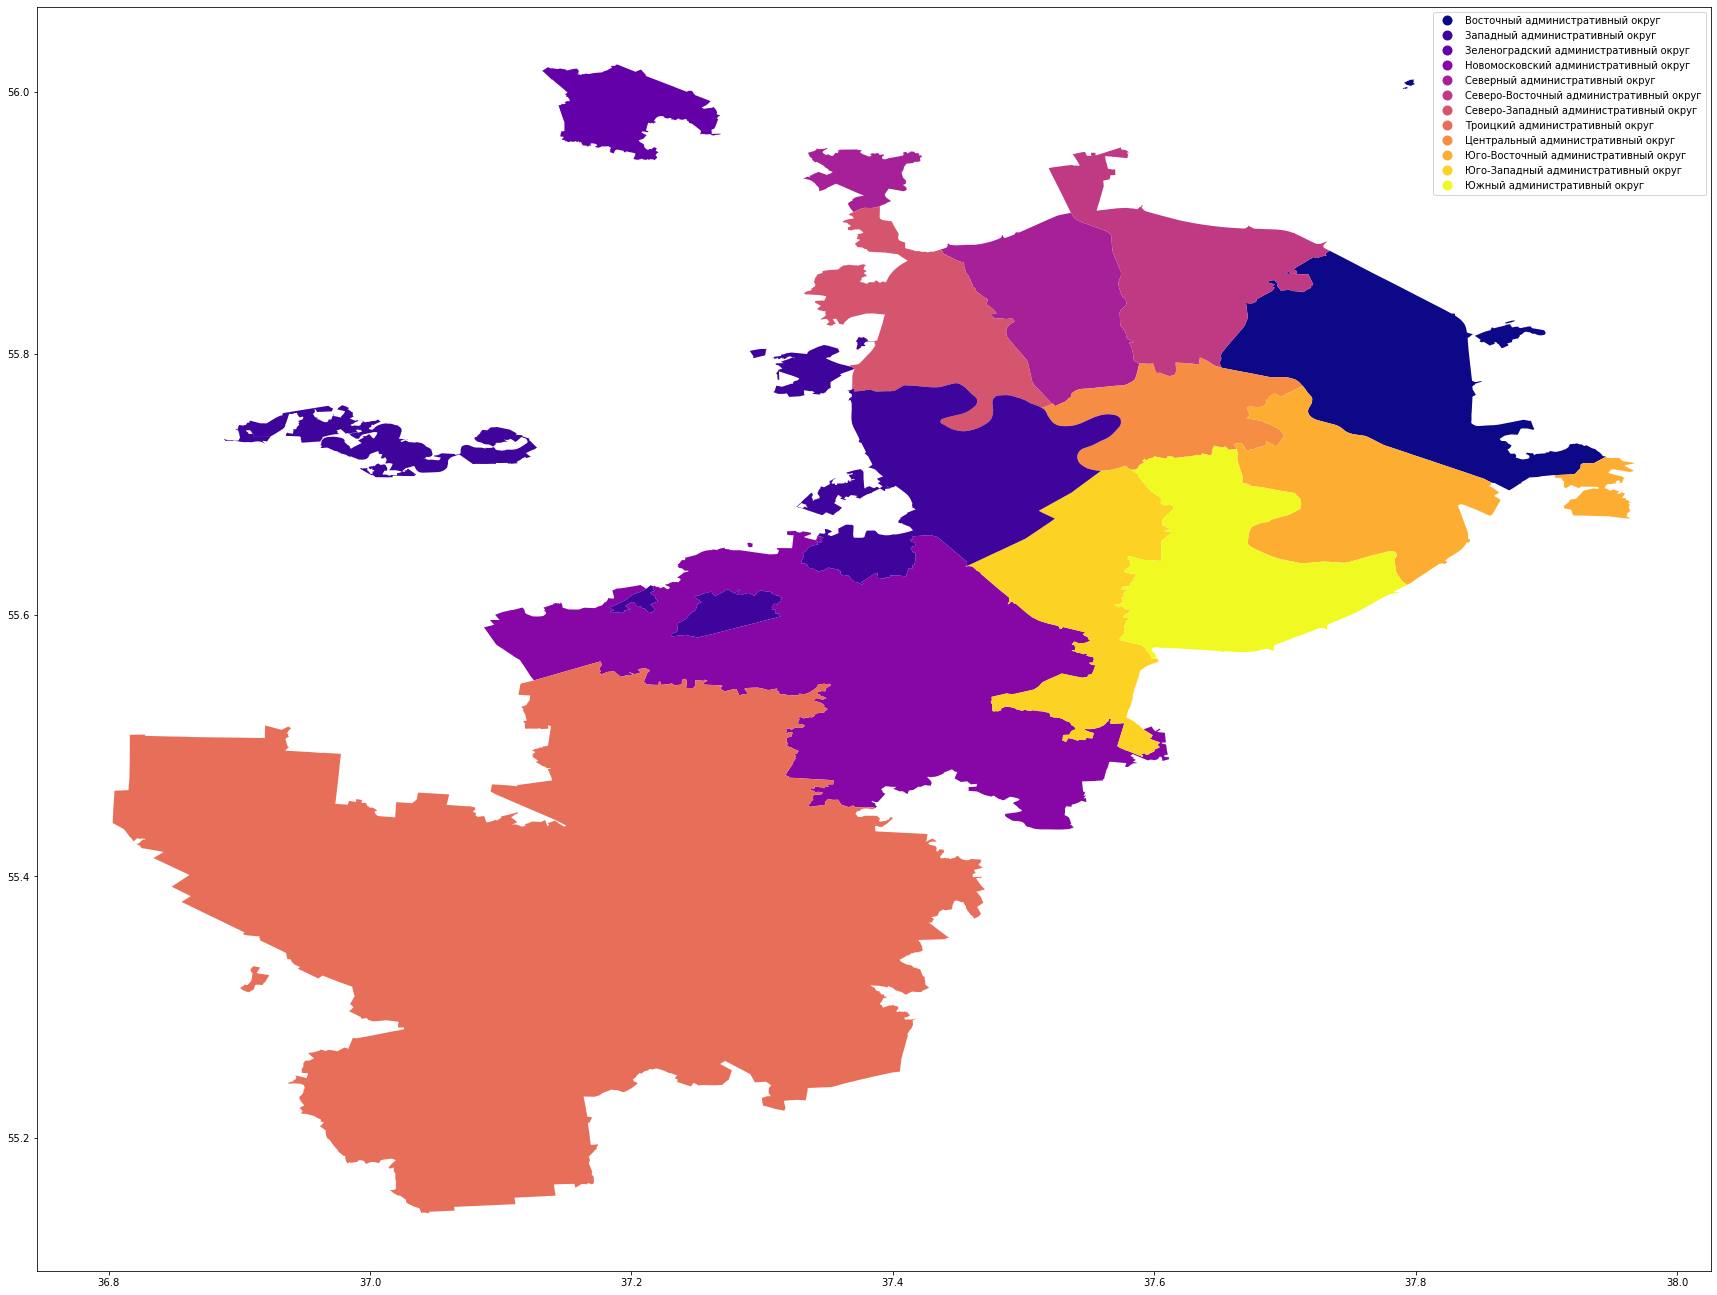

In [170]:
#по округам

m_gdf_wm = boundary_L5.to_crs({'init' :'epsg:4326'})
m_gdf_wm.plot(column = 'NAME', linewidth=0.5, cmap='plasma', legend=True, figsize=[30,30])

<AxesSubplot:>

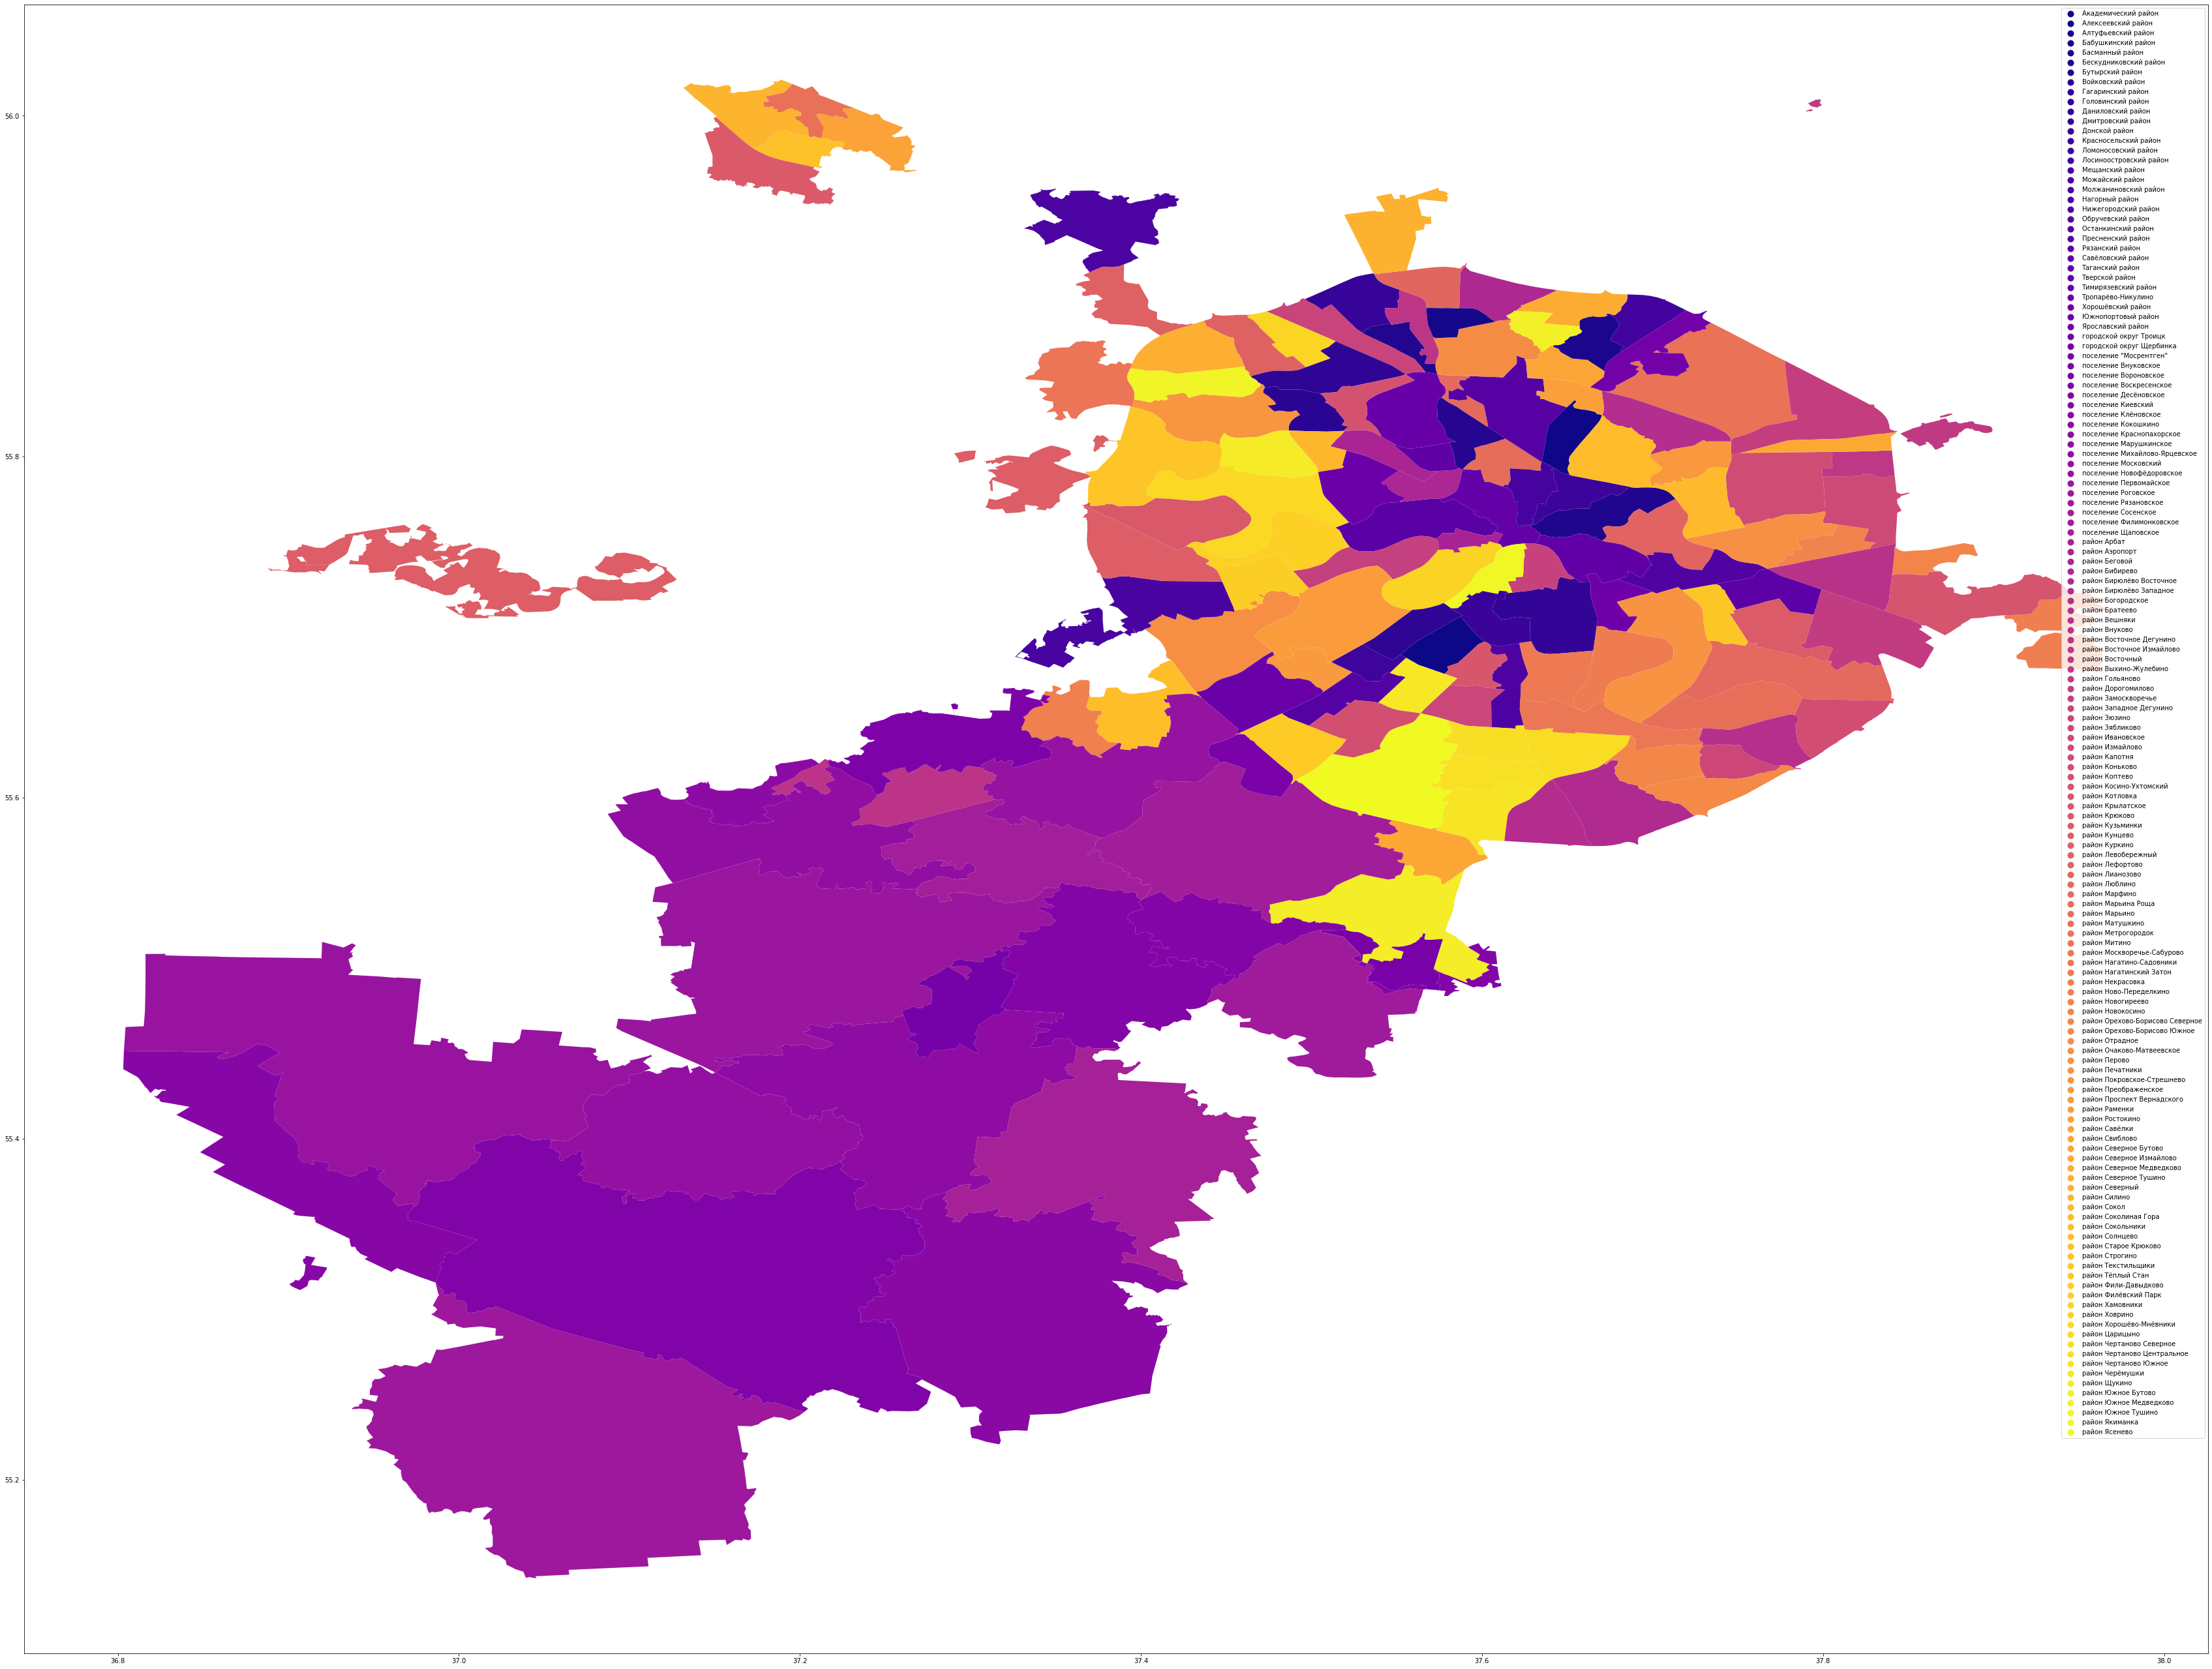

In [3]:
#по районам цветная
m_gdf_wm = boundary_L8.to_crs({'init' :'epsg:4326'})
m_gdf_wm.plot(column = 'NAME', linewidth=0.5, cmap='plasma', legend=True, figsize=[60,60])

In [4]:
m_gdf_wm.to_file("m_gdf_new.shp", encoding='utf-8') #сохраняем в .shp

### 4.	Описываю алгоритм поиска близких объектов (по положению в пространстве), в двух похожих точечных слоях. 

In [102]:
#shp на вход
building_point.head()

,BUILDING,ADDR_CITY,A_STRT,A_SBRB,A_HSNMBR,ADDR_PLACE,A_PSTCD,B_LEVELS,NAME,NAME_EN,NAME_RU,OSM_TYPE,OSM_ID,geometry
0,yes,None,Полевая улица,None,10,None,None,None,None,None,None,node,3125371445,POINT (37.58282 55.49864)
1,kiosk,None,None,None,None,None,None,1,Проездные билеты,Public transport tickets,Проездные билеты,node,3304018325,POINT (37.60174 55.61146)
2,service,None,None,None,None,None,None,1,None,None,None,node,3486652125,POINT (37.35333 55.85486)
3,bunker,None,None,None,None,None,None,None,бомбоубежище,None,None,node,638742556,POINT (37.16979 55.99401)
4,kiosk,None,None,None,None,None,None,None,Мороженое,None,None,node,3507393823,POINT (37.83830 55.76785)


In [25]:
geom = building_point.loc[:, ['geometry']]

<AxesSubplot:>

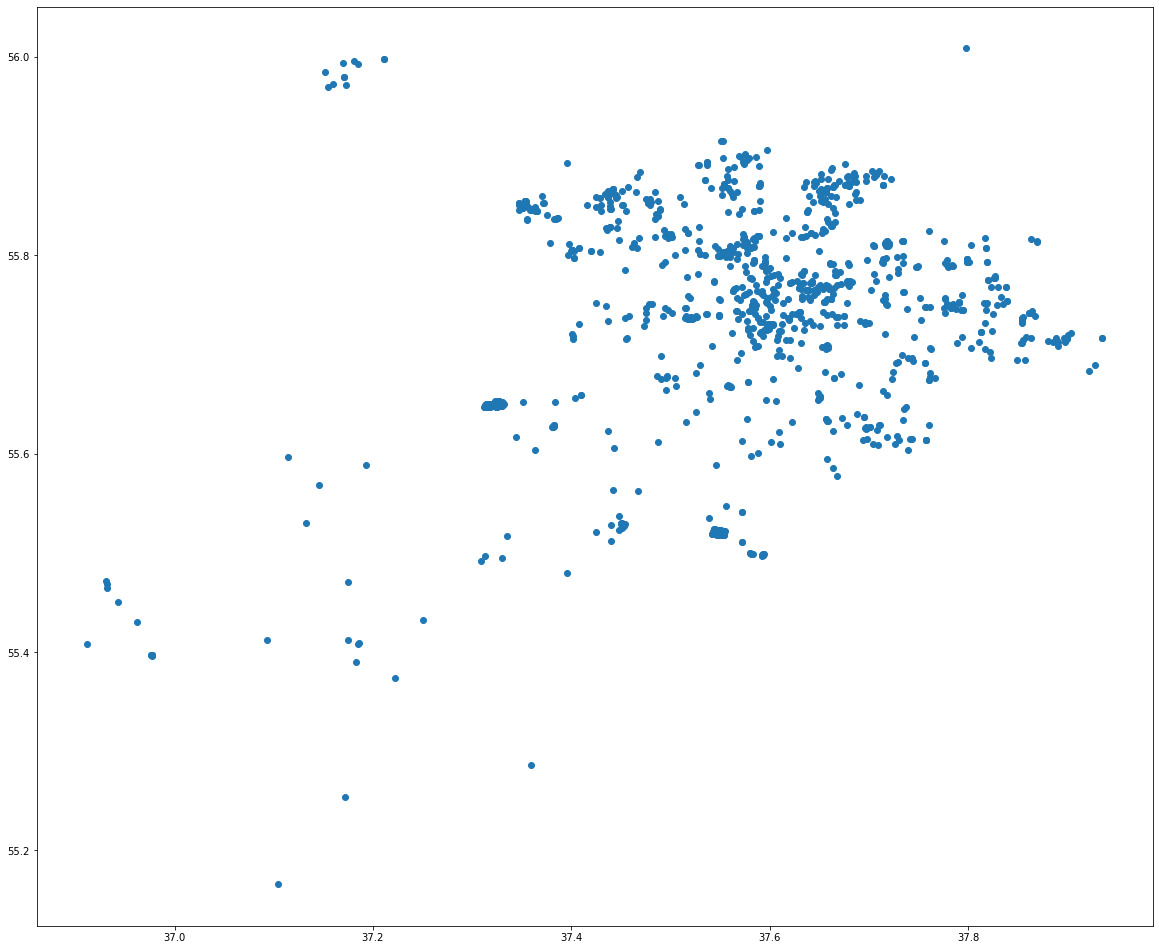

In [103]:
geom.plot(figsize=(20,20))

In [162]:
pressa = building_point[building_point['NAME'] == 'Пресса']
pressa = pressa[['NAME', 'geometry']]
# pressa

In [163]:
proezd = building_point[building_point['NAME'] == 'Проездные билеты']
proezd = proezd[['NAME', 'geometry']]
# proezd

<AxesSubplot:>

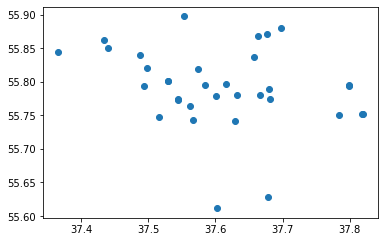

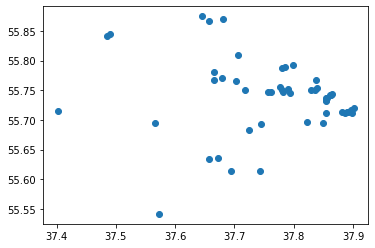

In [164]:
#будем сравнивать удалённость друг от друга киосков прессы и киосков проездных билетов
proezd.plot()
pressa.plot()

In [167]:
#буфер пересечения -- 2000 м
proezd['geometry']= proezd.buffer(2000)
pressa['geometry']= pressa.buffer(2000)

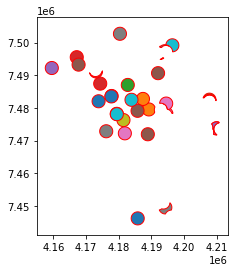

In [203]:
#вне пересечений
cores = gpd.overlay(proezd, pressa, how='difference')
cores.plot(alpha=1, edgecolor='r', cmap='tab10');

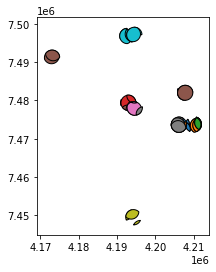

In [207]:
#пересечения
cores = gpd.overlay(proezd, pressa, how='intersection')
cores.plot(alpha=1, edgecolor='k', cmap='tab10');

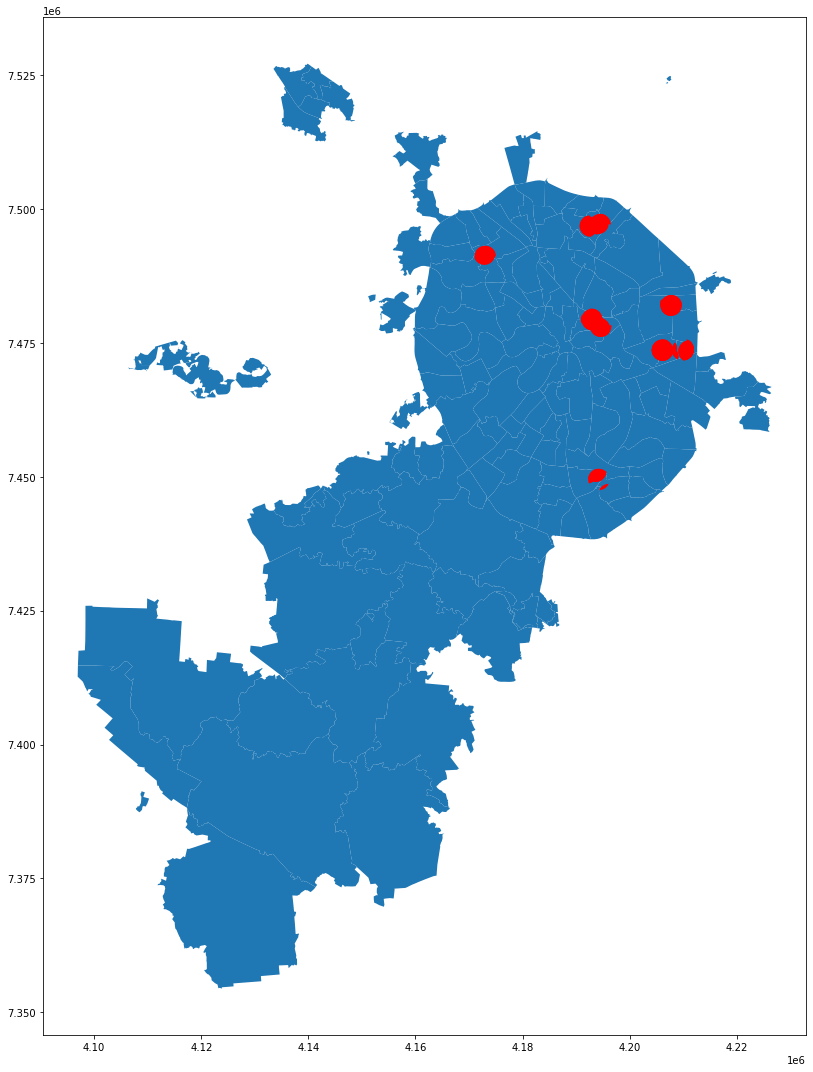

In [208]:
#на карте отображаем места, где отделения пересекаются в 2000 м. 
fig, ax = plt.subplots(figsize=(15,15))
boundary_L81.plot(ax=ax)
cores.plot(markersize=0.5, color='red',ax=ax)
plt.tight_layout()
plt.show()

In [209]:
#датафрейм пересечений
cores.head()

,NAME_1,NAME_2,geometry
0,Проездные билеты,Пресса,"POLYGON ((4208386.469 7472634.237, 4208364.461..."
1,Проездные билеты,Пресса,"POLYGON ((4208276.026 7472512.382, 4208215.538..."
2,Проездные билеты,Пресса,"POLYGON ((4208145.901 7473675.219, 4208136.270..."
3,Проездные билеты,Пресса,"POLYGON ((4209054.047 7472029.527, 4208916.260..."
4,Проездные билеты,Пресса,"POLYGON ((4209019.726 7471901.490, 4208935.683..."


### 5.	Используя файл реформы ЖКХ, получаю точки жилых домов.

In [4]:
df = pd.read_csv("Татарстан.csv", sep='\;', comment='#', encoding='utf-8')

<ipython-input-4-866abfcdda2d>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("Татарстан.csv", sep='\;', comment='#', encoding='utf-8')


In [383]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       20001 non-null  int64  
 1   region_id                19961 non-null  object 
 2   area_id                  12163 non-null  object 
 3   city_id                  19961 non-null  object 
 4   street_id                19858 non-null  object 
 5   shortname_region         19961 non-null  object 
 6   formalname_region        19961 non-null  object 
 7   shortname_area           12163 non-null  object 
 8   formalname_area          12163 non-null  object 
 9   shortname_city           19961 non-null  object 
 10  formalname_city          19961 non-null  object 
 11  shortname_street         19858 non-null  object 
 12  formalname_street        19858 non-null  object 
 13  house_number             20001 non-null  object 
 14  address               

In [361]:
def fetch_coordinates(place, apikey):
    base_url = "https://geocode-maps.yandex.ru/1.x"
    params = {"geocode": place, "apikey": apikey, "format": "json"}
    response = requests.get(base_url, params=params)
    response.raise_for_status()
    places_found = response.json()['response']['GeoObjectCollection']['featureMember']
    most_relevant = places_found[0]
    lon, lat = most_relevant['GeoObject']['Point']['pos'].split(" ")
    return lon, lat

def carried(api_key):
    return lambda place: fetch_coordinates(place, api_key)
fetch_coordinates_with_api_key = carried("acc00ae7-895f-4401-a50d-c280a156cd68")

In [385]:
#с помощью геокодера от Яндекса обращаемся к каждому адресу и получаем координаты. 
df['points'] = df['address'].progress_apply(fetch_coordinates_with_api_key)

100%|██████████| 20001/20001 [1:11:57<00:00,  4.63it/s]


In [105]:
df.tail()

,id,a_place,address,quarters_count,living_quarters_count,pers_per_quarters,unliving_quarters_count,area_total,Density,points,lat,lon
19996,6889800,Татарстан,"Респ. Татарстан, р-н. Ютазинский, с. Ютаза, ул...",18,18.0,"46,8",0.0,"861,60","0,05432","(53.264455, 54.59038)",53.264455,54.590380
19997,6889803,Татарстан,"Респ. Татарстан, р-н. Ютазинский, с. Ютаза, ул...",16,16.0,"41,6",0.0,"780,90","0,05327","(53.268839, 54.589785)",53.268839,54.589785
19998,6889806,Татарстан,"Респ. Татарстан, р-н. Ютазинский, с. Ютаза, ул...",16,16.0,"41,6",0.0,"786,30","0,05291","(53.268219, 54.589519)",53.268219,54.589519
19999,6875028,Татарстан,"ул. Х.Такташ, д. 1 (дубль 1)",27,NaN,0,NaN,"1629,00","0,00000","(49.131387, 55.78037)",49.131387,55.780370
20000,6875061,Татарстан,"ул. Х.Такташ, д. 3",24,NaN,0,NaN,"1395,30","0,00000","(49.514025, 56.284294)",49.514025,56.284294


In [3]:
#удаляем лишний индекс
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       20001 non-null  int64  
 1   a_place                  20001 non-null  object 
 2   address                  20001 non-null  object 
 3   quarters_count           20001 non-null  int64  
 4   living_quarters_count    15868 non-null  float64
 5   pers_per_quarters        20001 non-null  object 
 6   unliving_quarters_count  15081 non-null  float64
 7   area_total               18880 non-null  object 
 8   Density                  18812 non-null  object 
 9   points                   20001 non-null  object 
 10  lat                      20001 non-null  float64
 11  lon                      20001 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory usage: 1.8+ MB


In [4]:
#переводим points в читамый для пространственных данных кортеж
from ast import literal_eval
df['points'] = df.points.apply(lambda x: tuple(map(float, literal_eval(x))))

In [5]:
#формируем столбцы с широтой и долготой
df['lat'] = df['points'].apply(lambda loc: tuple(loc)[0] if loc else None)
df['lon'] = df['points'].apply(lambda loc: tuple(loc)[1] if loc else None)

In [6]:
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20001 entries, 0 to 20000
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       20001 non-null  int64  
 1   a_place                  20001 non-null  object 
 2   address                  20001 non-null  object 
 3   quarters_count           20001 non-null  int64  
 4   living_quarters_count    15868 non-null  float64
 5   pers_per_quarters        20001 non-null  object 
 6   unliving_quarters_count  15081 non-null  float64
 7   area_total               18880 non-null  object 
 8   Density                  18812 non-null  object 
 9   points                   20001 non-null  object 
 10  lat                      20001 non-null  float64
 11  lon                      20001 non-null  float64
dtypes: float64(4), int64(2), object(6)
memory usage: 1.8+ MB


In [7]:
#меняем формат str на float64
df['Density'] = df['Density'].str.replace(',','.').astype(np.float64)

In [8]:
df.sample(50)

,id,a_place,address,quarters_count,living_quarters_count,pers_per_quarters,unliving_quarters_count,area_total,Density,points,lat,lon
9441,9104735,Татарстан,"Респ. Татарстан, г. Казань, ул. Лево-Булачная,...",14,13.0,"33,8",1.0,"820,87",0.04118,"(49.112783, 55.787675)",49.112783,55.787675
7303,6904218,Татарстан,"Респ. Татарстан, г. Казань, ул. Бутлерова, д. 21А",12,12.0,"31,2",0.0,"1593,20",0.01958,"(49.129815, 55.788252)",49.129815,55.788252
3303,6892260,Татарстан,"Респ. Татарстан, р-н. Бугульминский, г. Бугуль...",8,8.0,"20,8",0.0,"541,90",0.03838,"(52.825493, 54.531481)",52.825493,54.531481
10442,6912048,Татарстан,"Респ. Татарстан, г. Казань, ул. Оренбургский т...",8,NaN,0,NaN,"365,40",0.00000,"(49.198132, 55.726649)",49.198132,55.726649
18818,6860397,Татарстан,"Респ. Татарстан, р-н. Чистопольский, г. Чистоп...",6,6.0,"15,6",0.0,"268,90",0.05801,"(50.655945, 55.374263)",50.655945,55.374263
3920,7414060,Татарстан,"Респ. Татарстан, р-н. Буинский, г. Буинск, ул....",12,12.0,"31,2",0.0,"656,10",0.04755,"(48.286324, 54.971693)",48.286324,54.971693
508,6898065,Татарстан,"Респ. Татарстан, р-н. Азнакаевский, г. Азнакае...",8,8.0,"20,8",0.0,"538,60",0.03862,"(53.078953, 54.840625)",53.078953,54.840625
4671,6896232,Татарстан,"Респ. Татарстан, р-н. Елабужский, г. Елабуга, ...",24,24.0,"62,4",0.0,"1050,50",0.05940,"(52.026756, 55.757592)",52.026756,55.757592
16829,6856491,Татарстан,"Респ. Татарстан, р-н. Нижнекамский, г. Нижнека...",215,215.0,559,0.0,"11951,00",0.04677,"(51.785208, 55.61722)",51.785208,55.617220
8667,6900834,Татарстан,"Респ. Татарстан, г. Казань, пр-кт. Ибрагимова,...",106,80.0,208,26.0,"3910,40",0.05319,"(49.099111, 55.825487)",49.099111,55.825487


In [9]:
#получаем атрибуты геометрии из созданных выше долготы и широты
gdt = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df['lat'], df['lon']))

In [10]:
#удаляем points, поскольку в данном примере эти данные больше не нужны
del gdt['points']

In [20]:
gdt.crs = "EPSG:4326"

In [21]:
gdt.to_file("gdt.shp", encoding='utf-8') #сохраняем в .shp